In this project, I will show two different approaches to sentiment analysis by using VADER Sentiment Analysis Tool and RobertA pretrained language model. 

I will start with importing the necessary packages. The dataset has almost 600k datapoints. To be able to save some time, I have chosen only the first 1000 datapoints. Otherwise, it can take up to 15 minutes to run the models in entire dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot') #it sets the style of the plots

df= pd.read_csv("../input/amazon-fine-food-reviews/Reviews.csv")
df = df.head(1000)
df.head()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [2]:
df.shape

(1000, 10)

I will make a basic visualization of each score and their abundancy with a bar plot. 

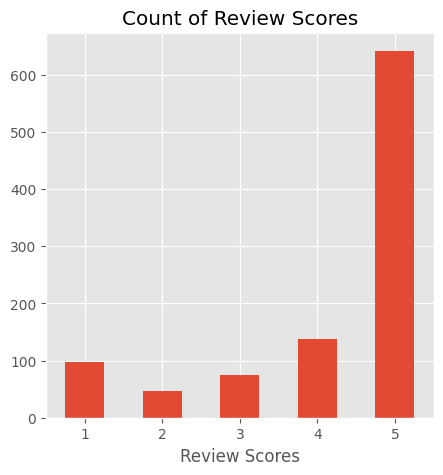

In [3]:
ax = df["Score"].value_counts().sort_index().plot(kind= "bar", title= "Count of Review Scores", figsize=(5,5))
ax.set_xlabel("Review Scores")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);

### VADER Sentiment Analysis

VADER is Valence Aware Dictionary and sEntiment Reasoner in short. VADER is a rule-based sentiment analysis tool that uses a lexicon of words and phrases with associated sentiment scores to analyze the sentiment of a text. Additionally, it takes into account the intensity of sentiment and the presence of negation in a sentence to provide a more accurate sentiment analysis result. 

I use the SentimentIntensityAnalyzer class from nltk.sentiment module, which is an NLTK implementation of VADER.

In [4]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia= SentimentIntensityAnalyzer()
sia.polarity_scores("I am very sad!")

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


{'neg': 0.648, 'neu': 0.352, 'pos': 0.0, 'compound': -0.5697}

As seen above, polarity_scores method gives four parameters: Negativity, neutrality, positivity and compound scores. The first three I believe quite clear, but to clarify the compound score: It basically positions the sentiment between -1 and 1. 1 is the most positive and -1 is the most negative in the spectrum. Now, I write a loop to calculate the each score for each sentiment and I will store the results in a dictionary.

In [5]:
res={}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text= row["Text"]
    myid= row["Id"]
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/1000 [00:00<?, ?it/s]

To work easily on the data, I need to convert the dictionary to dataframe. With the ".T" attribute, I will transpose the dataframe to match the shape of df. Then, I will combine the VADER results with df. One important point is here that to be able to merge them togther, I need a column with the same name in both dataframes. So, I change the name of the index column of vaders result to "Id", so it matches with the "Id" column in df. 

In [6]:
vaders = pd.DataFrame(res).T
vaders= vaders.reset_index().rename(columns={"index": "Id"})
vaders= vaders.merge(df, how="left")
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Now, I have results of VADER Sentiment analysis and the scores given by the customers. I will check, what is the distribution of Compound Score according to Amazon Scores. For that, I use barplot from seaborn library. 

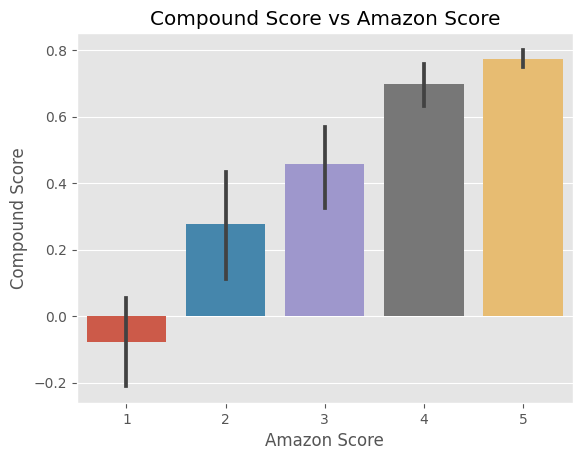

In [7]:
ax = sns.barplot(data=vaders, x="Score", y="compound")
ax.set_title("Compound Score vs Amazon Score")
ax.set_xlabel("Amazon Score")
ax.set_ylabel("Compound Score");

The Compound score seems to be relevant to the Amazon scores in which 1 has negative values in compound score, while 5 has the highest positive compound score. Finally, I will plot the same barplots this time with negative, positive and neutral scores vs Amazon score.

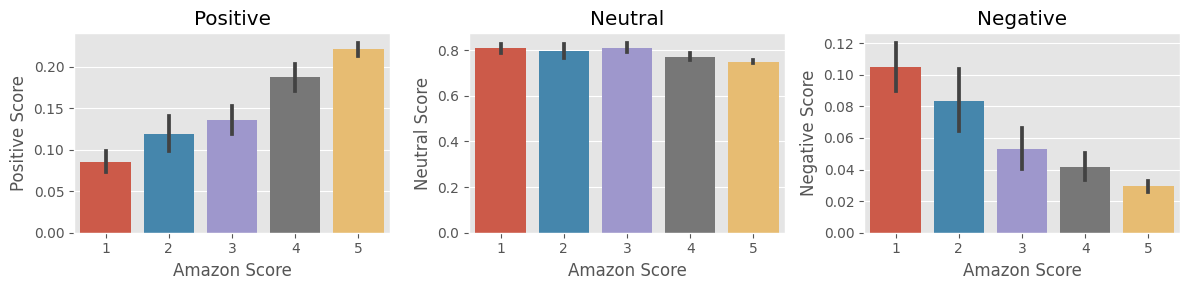

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
axs[0].set_xlabel("Amazon Score")
axs[1].set_xlabel("Amazon Score")
axs[2].set_xlabel("Amazon Score")
axs[0].set_ylabel("Positive Score")
axs[1].set_ylabel("Neutral Score")
axs[2].set_ylabel("Negative Score")
plt.tight_layout();

The barplots seem to be logical. Especially, when I look at the positive score vs Amazon score, I see that score 1 has the lowest positive score as it should be and vice versa for negative score. 

#### RobertA Pretrained Language Model:

At the second part of the project, I will use RobertA for sentiment analysis.

RobertA is Robustly Optimized BERT Pretraining Approach in short. It is a state-of-the-art pretrained language model based on the Transformer architecture. RobertA is usually used for more complex NLP tasks such as language generation or question answering, however, can be used also for sentiment analysis. To be able to use this model, first I will import the necessary classes and the softmax function.

In [9]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

I use the pre-trained sentiment analysis model based on the Twitter RoBERTa architecture from the Hugging Face Transformers library.

The model can be accessed from the link below: 

https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment

In [10]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Now, as in VADER analyis, I will write a function to acquire relevant parameters from RobertA, as well. So, that I can make a direct comparison between the two. 

First, I tokenize the text, breaking down the text into smaller pieces called tokens. Then, with "return_tensors="pt", I convert these tokens to pytorch tensors, which are the representative of numerical data. In other words, we associate these tokens (words, subwords) with numbers, so that the model can make mathematical calculations. Then, with the model, I provide the text to be analyzed to RobertA and get the output. I convert the output to numpy array and transform it into the probability scores such as "negative, positive and neutral". I store all in a dictionary.

In [11]:
def polarity_scores_roberta(exp):
    encoded_text = tokenizer(exp, return_tensors="pt")
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores=softmax(scores)
    scores_dict = {
        "roberta_neg" : scores [0],
        "roberta_neu" : scores[1],
        "roberta_pos" : scores[2]
    }
    return (scores_dict)

With a another loop, I will apply it to the entire dataset combined with VADER analysis results. While the code is running, it gets broken for certain Ids, where RobertA encounters with a problem to process. To skip those datapoints, I add RuntimeError exception as a simple debugging so that it runs smoothly.

In [12]:
from tqdm.notebook import tqdm
res={}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text= row["Text"]
        myid= row["Id"]
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f"Broke for id {myid}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863


As in VADER, I convert the dictionary to dataframe and I combine it with df. 

In [18]:
df_final = pd.DataFrame(res).T
df_final= df_final.reset_index().rename(columns={"index": "Id"})
df_final= df_final.merge(df, how="left")
df_final.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Comparison of RobertA and VADER:

I will use pairplot from the seaborn library to visualize the relationsship between two variables, which are sentiment scores from both RobertA and VADER.

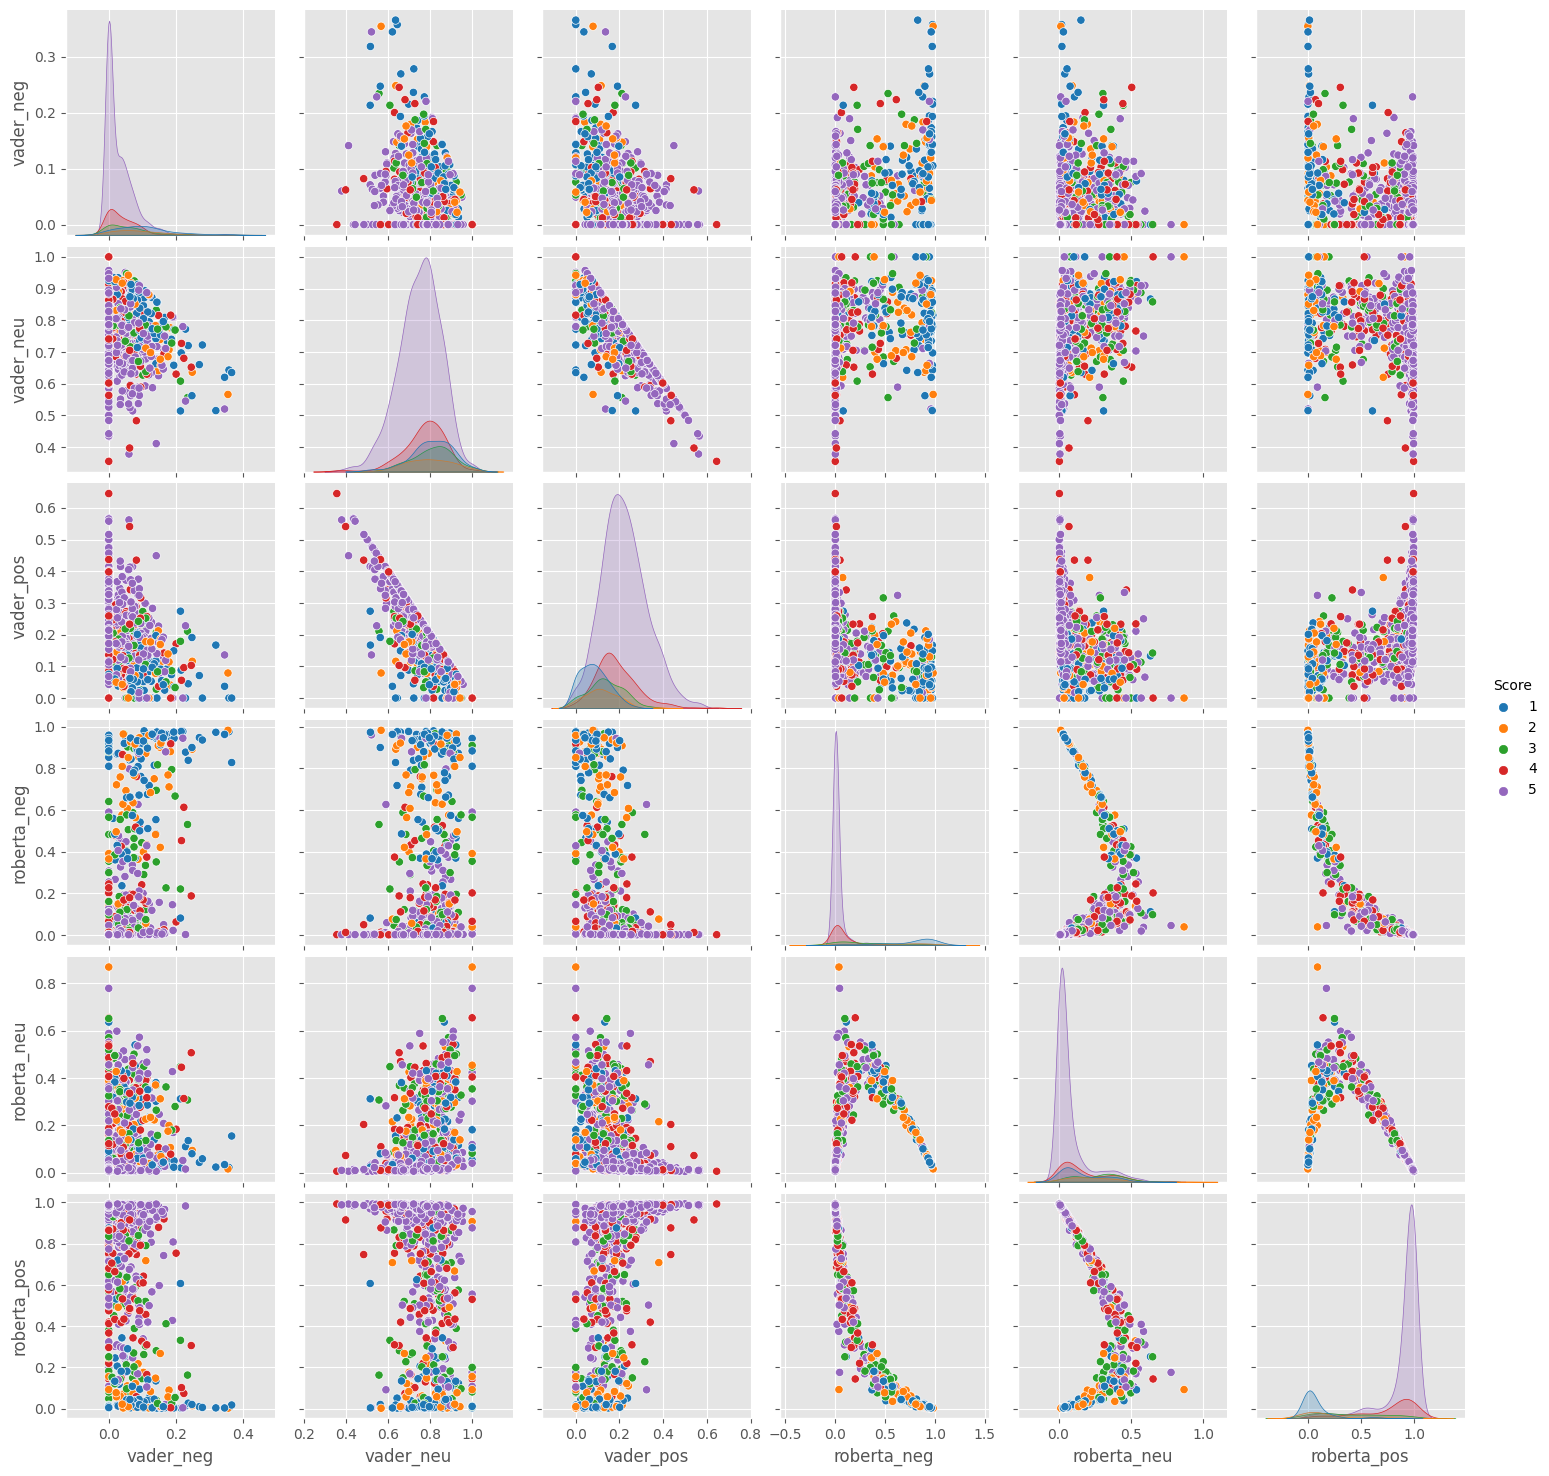

In [19]:
sns.pairplot(data=df_final, vars=["vader_neg", "vader_neu", "vader_pos", "roberta_neg", "roberta_neu", "roberta_pos"], 
             hue="Score", palette="tab10");

When I look at the plots, we can make an overall prediction about the performance of RobertA and VADER: RobertA seems to cluster scores better compared to VADER. 

Now, I will try to determine the most confusing sentiments for each, RobertA and VADER for Score 1 and 5.

In [37]:
df_final.query("Score == 5").sort_values("vader_neg", ascending= False)["Text"].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [38]:
df_final.query("Score == 5").sort_values("roberta_neg", ascending= False)["Text"].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [39]:
df_final.query("Score == 1").sort_values("vader_pos", ascending= False)["Text"].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [40]:
df_final.query("Score == 1").sort_values("roberta_pos", ascending= False)["Text"].values[0]

"I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months."

So, overall RobertA seems to do better based on the graphical demonstration, however, we see also that ironic sentences decreases the accuracy of the models, since the model cannot interpret and conclude it as irony. 